##  Étape 1 :Description du projet
Le paludisme est une maladie mortelle causée par des parasites transmis à l'homme par les piqûres de moustiques infectés. Le diagnostic et le traitement précoces du paludisme sont essentiels pour réduire les taux de morbidité et de mortalité. C’est dans ce cadre que s'inscrit ce projet qui a pour objectif de mettre en place un système qui permet de déterminer si une personne est atteint du paludisme ou non à travers des images sanguine


##  Étape 2 : Collecte des données

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:10<00:00, 69.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [3]:
# importation des bibliothèque

import os

## Étape 3 : Explorer le dataset

In [4]:
import os

# Chemin vers le dataset
dataset_path = "/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images"

# Vérifier le contenu du dossier
print("Dossiers disponibles :", os.listdir(dataset_path))


Dossiers disponibles : ['Parasitized', 'cell_images', 'Uninfected']


In [5]:
# Chemin vers les dossiers des images
parasitized_path = os.path.join(dataset_path, "Parasitized")
uninfected_path = os.path.join(dataset_path, "Uninfected")

# Compter le nombre d'images dans chaque dossier
num_parasitized = len(os.listdir(parasitized_path))
num_uninfected = len(os.listdir(uninfected_path))

print(f"Nombre d'images infectées (Parasitized) : {num_parasitized}")
print(f"Nombre d'images saines (Uninfected) : {num_uninfected}")


Nombre d'images infectées (Parasitized) : 13780
Nombre d'images saines (Uninfected) : 13780


## Étape 4 : Afficher quelques images

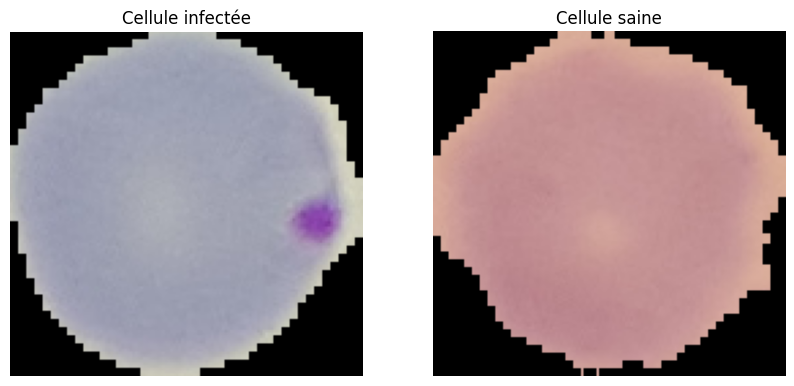

In [6]:
import matplotlib.pyplot as plt
import cv2

# Charger une image infectée et une image saine
infected_img = cv2.imread(os.path.join(dataset_path, 'Parasitized', os.listdir(os.path.join(dataset_path, 'Parasitized'))[0]))
healthy_img = cv2.imread(os.path.join(dataset_path, 'Uninfected', os.listdir(os.path.join(dataset_path, 'Uninfected'))[0]))

# Convertir les couleurs BGR -> RGB (pour un affichage correct)
infected_img = cv2.cvtColor(infected_img, cv2.COLOR_BGR2RGB)
healthy_img = cv2.cvtColor(healthy_img, cv2.COLOR_BGR2RGB)

# Affichage
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(infected_img)
axes[0].set_title("Cellule infectée")
axes[0].axis("off")

axes[1].imshow(healthy_img)
axes[1].set_title("Cellule saine")
axes[1].axis("off")

plt.show()


## Étape 5 : Prétraitement des images

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
import os

# Définir la taille des images
IMG_SIZE = 64  # Taille choisie (64x64 pixels)
data = []  # Liste pour stocker les images prétraitées
labels = []  # Liste pour stocker les étiquettes

# Parcourir les dossiers et charger les images
for category in ["Parasitized", "Uninfected"]:
    folder_path = os.path.join(dataset_path, category)
    label = 1 if category == "Parasitized" else 0  # 1 pour infecté, 0 pour sain

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)

        try:
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Charger et redimensionner l'image
            img_array = img_to_array(img)  # Convertir en tableau
            img_array = img_array / 255.0  # Normalisation (valeurs entre 0 et 1)

            data.append(img_array)
            labels.append(label)

        except Exception as e:
            print(f"⚠️ Erreur avec l'image {img_path} : {e}")

# Convertir les listes en tableaux numpy
X = np.array(data)
y = np.array(labels)

print(f"✅ Nombre total d'images chargées : {len(X)}")
print(f"✅ Forme des images : {X.shape}")
print(f"✅ Nombre d'étiquettes : {len(y)}")


⚠️ Erreur avec l'image /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/Thumbs.db : cannot identify image file <_io.BytesIO object at 0x7b8f9a979170>
⚠️ Erreur avec l'image /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/Thumbs.db : cannot identify image file <_io.BytesIO object at 0x7b9012ccf830>
✅ Nombre total d'images chargées : 27558
✅ Forme des images : (27558, 64, 64, 3)
✅ Nombre d'étiquettes : 27558


## Étape suivante : Séparer le dataset en train/test

In [8]:
from sklearn.model_selection import train_test_split

# Séparer les données en 80% train et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier la répartition
print(f"🔹 Nombre d'images d'entraînement : {len(X_train)}")
print(f"🔹 Nombre d'images de test : {len(X_test)}")


🔹 Nombre d'images d'entraînement : 22046
🔹 Nombre d'images de test : 5512


## Étape 6 : Construire un modèle

Construisez un CNN simple avec Keras

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Définition du modèle CNN
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # 1 Neurone pour prédire "Infecté" (1) ou "Sain" (0)
])

# Afficher l'architecture du modèle
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

2 Compiler le modèle

In [10]:
model.compile(
    loss="binary_crossentropy",  # Car c'est une classification binaire
    optimizer="adam",            # Bon choix pour ce type de problème
    metrics=["accuracy"]         # Pour évaluer la performance
)


3 Entraîner le modèle

In [11]:
history = model.fit(
    X_train, y_train,  # Données d'entraînement
    epochs=10,         # Nombre d'itérations
    batch_size=32,     # Nombre d'images traitées en parallèle
    validation_data=(X_test, y_test)  # Vérification sur données de test
)


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 151s 217ms/step - accuracy: 0.7445 - loss: 0.4706 - val_accuracy: 0.9492 - val_loss: 0.1540
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 204s 220ms/step - accuracy: 0.9565 - loss: 0.1356 - val_accuracy: 0.9559 - val_loss: 0.1422
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 199s 216ms/step - accuracy: 0.9559 - loss: 0.1274 - val_accuracy: 0.9510 - val_loss: 0.1485
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 201s 215ms/step - accuracy: 0.9616 - loss: 0.1117 - val_accuracy: 0.9458 - val_loss: 0.1553
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - accuracy: 0.9641 - loss: 0.1021 - val_accuracy: 0.9577 - val_loss: 0.1308
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 203s 218ms/step - accuracy: 0.9690 - loss: 0.0902 - val_accuracy: 0.9501 - val_loss: 0.1590
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 199s 214ms/step - accuracy: 0.9713 - loss: 0.0833 - val_accuracy: 0.9526 - val_loss: 0.1412
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 214s 232ms/step - accuracy: 0.9763 -

Évaluer le modèle

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Précision sur les données de test : {test_acc:.2%}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9537 - loss: 0.1708
✅ Précision sur les données de test : 95.07%


In [13]:
from joblib import dump, load

# Sauvegarder le modèle
dump(model, 'model.joblib')

# Méthode 2: Utilisant pickle
import pickle

# Sauvegarder le modèle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)